In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import keras

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import time
from tabulate import tabulate

In [2]:
# read dataset
df = pd.read_csv("Dataset/bank_marketing/bank-additional/bank-additional/bank-additional-full.csv", delimiter=";")

In [3]:
# preprocessing steps for numerical and categorical data (replace y, replace missing value, encode, scale)
# replace 'yes' with 1 and 'no' with 0
df['y'] = df['y'].replace({'yes': 1, 'no': 0})

numeric_features = df.drop(["y"], axis = 1).select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.drop(["y"], axis = 1).select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

C:\Users\PC\AppData\Local\Temp\ipykernel_708\3558439397.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


In [4]:
# split dataset
X = df.drop(['y'], axis=1)
y = df['y']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=30)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=30)

In [5]:
# oversampling
ros = RandomOverSampler(random_state=30)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [6]:
# storing performance result
performance_result = [
    ["Algorithm", "Accuracy", "Precision", "Recall", "F1 Score", "Duration"]
]

In [7]:
# function for performance metrics
def print_performance(y_test, y_pred, model, et, st):
    # confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Converted', 'Converted'],
                yticklabels=['Not Converted', 'Converted'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    performance_result.append([model, accuracy, precision, recall, f1, et - st])

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Duration (s): {et-st}")

In [8]:
# cross validation functions
def model_cross_validation(model, name, X_training):
    cv_scores = cross_validate(model, X_training, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
    
    cv_results_df = pd.DataFrame({
        "Fold": [1, 2, 3, 4, 5],
        "Accuracy": cv_scores['test_accuracy'],
        "Precision": cv_scores['test_precision'],
        "Recall": cv_scores['test_recall'],
        "F1-Score": cv_scores['test_f1']
    })

    cv_results_df.loc["Mean"] = ["Mean Accuracy", cv_scores['test_accuracy'].mean(), cv_scores['test_precision'].mean(), cv_scores['test_recall'].mean(), cv_scores['test_f1'].mean()]
    cv_results_df.loc["Std Dev"] = ["Mean Standard Deviation", cv_scores['test_accuracy'].std(), cv_scores['test_precision'].std(), cv_scores['test_recall'].std(), cv_scores['test_f1'].std()]
    cv_results_df.to_csv(str(name) + "_cross_validation.csv", index=False)

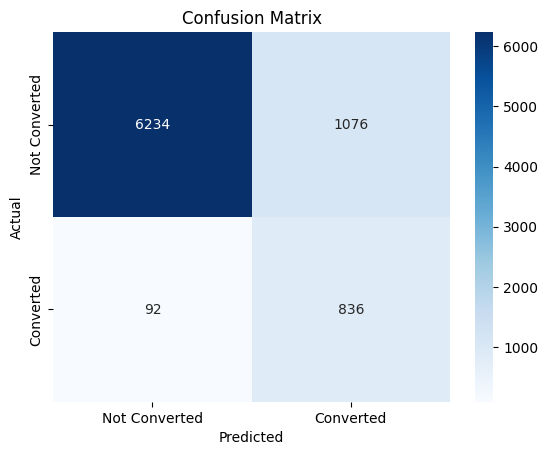

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      7310
           1       0.44      0.90      0.59       928

    accuracy                           0.86      8238
   macro avg       0.71      0.88      0.75      8238
weighted avg       0.92      0.86      0.88      8238

Accuracy: 0.8582180140810877
Precision: 0.923700759580854
Recall: 0.8582180140810877
F1 Score: 0.877664614975738
Duration (s): 0.3200070858001709


In [9]:
# lr
st = time.time()
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression(max_iter = 1000))])

lr_model.fit(X_train, y_train)
et = time.time()

y_pred = lr_model.predict(X_test)

print_performance(y_test, y_pred, "LR", et, st)
model_cross_validation(lr_model, "lr", X_train)

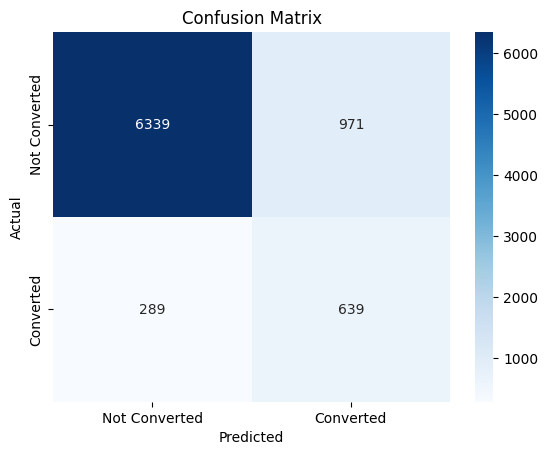

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      7310
           1       0.40      0.69      0.50       928

    accuracy                           0.85      8238
   macro avg       0.68      0.78      0.71      8238
weighted avg       0.89      0.85      0.86      8238

Accuracy: 0.8470502549162418
Precision: 0.8933698515178166
Recall: 0.8470502549162418
F1 Score: 0.8638582499037984
Duration (s): 0.12999558448791504


In [10]:
# knn
st = time.time()
knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', KNeighborsClassifier())])

knn_model.fit(X_train, y_train)
et = time.time()

y_pred = knn_model.predict(X_test)

print_performance(y_test, y_pred, "KNN", et, st)
model_cross_validation(knn_model, "knn", X_train)

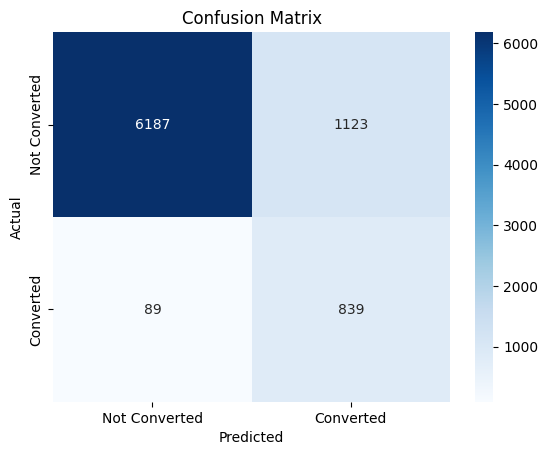

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      7310
           1       0.43      0.90      0.58       928

    accuracy                           0.85      8238
   macro avg       0.71      0.88      0.75      8238
weighted avg       0.92      0.85      0.87      8238

Accuracy: 0.8528769118718136
Precision: 0.9229391503403872
Recall: 0.8528769118718136
F1 Score: 0.8735975590847257
Duration (s): 48.05853009223938


In [11]:
# svm
st = time.time()
svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC())])

svm_model.fit(X_train, y_train)
et = time.time()

y_pred = svm_model.predict(X_test)

print_performance(y_test, y_pred, "SVM", et, st)
model_cross_validation(svm_model, "svm", X_train)

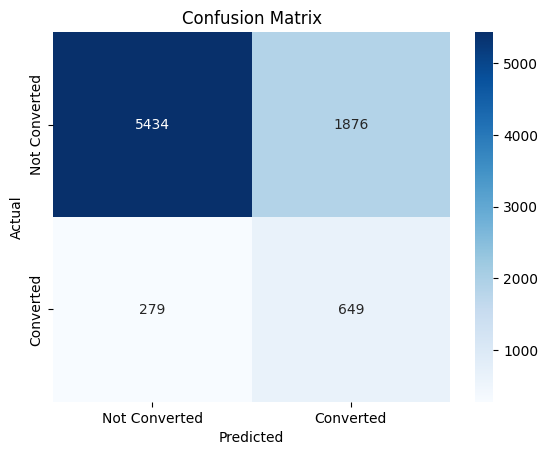

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.74      0.83      7310
           1       0.26      0.70      0.38       928

    accuracy                           0.74      8238
   macro avg       0.60      0.72      0.61      8238
weighted avg       0.87      0.74      0.78      8238

Accuracy: 0.7384073804321437
Precision: 0.8729706835840024
Recall: 0.7384073804321437
F1 Score: 0.7828607541066243
Duration (s): 0.16614794731140137


In [12]:
# nb
st = time.time()
nb_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', BernoulliNB())])

nb_model.fit(X_train, y_train)
et = time.time()

y_pred = nb_model.predict(X_test)

print_performance(y_test, y_pred, "NB", et, st)
model_cross_validation(nb_model, "nb", X_train)

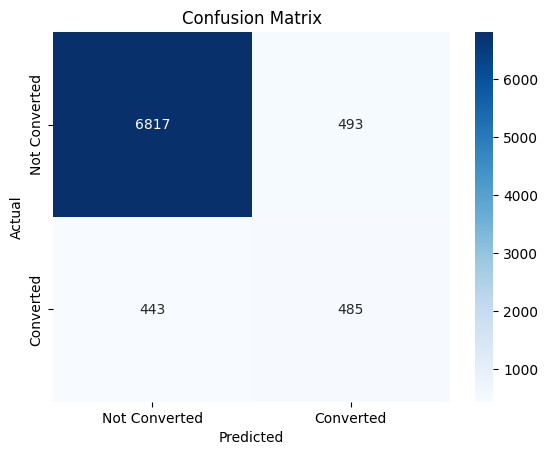

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      7310
           1       0.50      0.52      0.51       928

    accuracy                           0.89      8238
   macro avg       0.72      0.73      0.72      8238
weighted avg       0.89      0.89      0.89      8238

Accuracy: 0.8863801893663511
Precision: 0.8890693778575112
Recall: 0.8863801893663511
F1 Score: 0.8876755256286982
Duration (s): 0.40425610542297363


In [13]:
# dt
st = time.time()
dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', DecisionTreeClassifier())])

dt_model.fit(X_train, y_train)
et = time.time()

y_pred = dt_model.predict(X_test)

print_performance(y_test, y_pred, "DT", et, st)
model_cross_validation(dt_model, "dt", X_train)

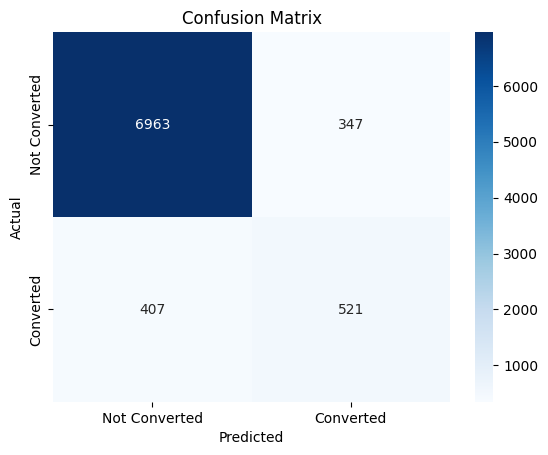

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7310
           1       0.60      0.56      0.58       928

    accuracy                           0.91      8238
   macro avg       0.77      0.76      0.76      8238
weighted avg       0.91      0.91      0.91      8238

Accuracy: 0.9084729303228939
Precision: 0.9059634932897078
Recall: 0.9084729303228939
F1 Score: 0.9071311261405908
Duration (s): 3.115161418914795


In [14]:
# rf
st = time.time()
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier())])

rf_model.fit(X_train, y_train)
et = time.time()

y_pred = rf_model.predict(X_test)

print_performance(y_test, y_pred, "RF", et, st)
model_cross_validation(rf_model, "rf", X_train)

C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


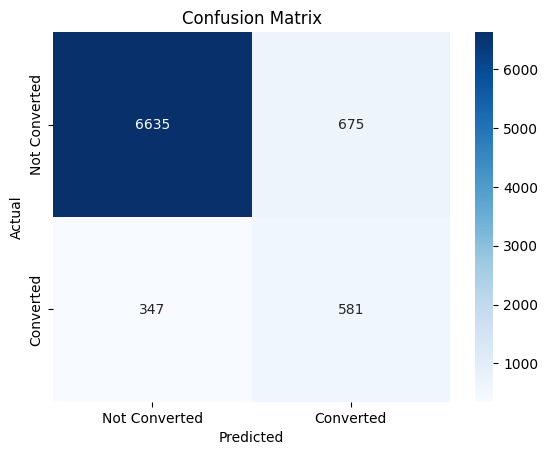

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7310
           1       0.46      0.63      0.53       928

    accuracy                           0.88      8238
   macro avg       0.71      0.77      0.73      8238
weighted avg       0.90      0.88      0.88      8238

Accuracy: 0.8759407623209516
Precision: 0.8953596187219244
Recall: 0.8759407623209516
F1 Score: 0.8838329922067935
Duration (s): 40.32612991333008


C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
# nn
st = time.time()
nn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', MLPClassifier())])

nn_model.fit(X_train, y_train)
et = time.time()

y_pred = nn_model.predict(X_test)

print_performance(y_test, y_pred, "NN", et, st)
model_cross_validation(nn_model, "nn", X_train)

C:\Users\PC\AppData\Local\Temp\ipykernel_708\2629766587.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  honn_model = KerasClassifier(build_fn=create_honn_model, epochs=10, batch_size=1, verbose=0)


258/258 [==============================] - 0s 940us/step


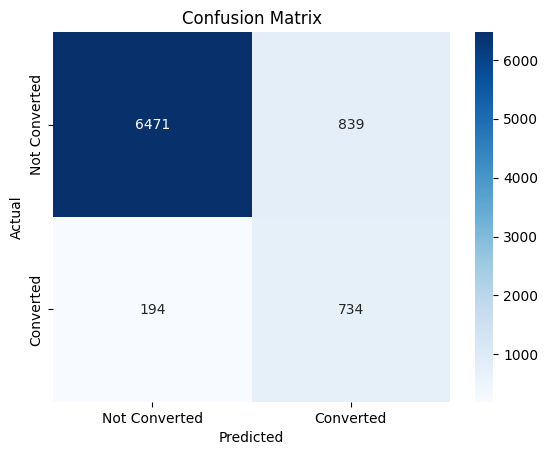

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      7310
           1       0.47      0.79      0.59       928

    accuracy                           0.87      8238
   macro avg       0.72      0.84      0.76      8238
weighted avg       0.91      0.87      0.89      8238

Accuracy: 0.8746054867686331
Precision: 0.9140875385714586
Recall: 0.8746054867686331
F1 Score: 0.8878811916695962
Duration (s): 729.563159942627
275/275 [==============================] - 0s 928us/step


In [16]:
# honn
def higher_order_nn(input_dim, order):
    inputs = Input(shape=(input_dim,))
    x = inputs

    for i in range(order):
        x = Dense(64, activation="relu")(x) # input layer

    outputs = Dense(1, activation="sigmoid")(x) # output layer

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def create_honn_model():
    input_dim = X_train_preprocessed.shape[1]
    order = 2
    model = higher_order_nn(input_dim, order)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

st = time.time()
X_train_preprocessed = preprocessor.fit_transform(X_train)
honn_model = KerasClassifier(build_fn=create_honn_model, epochs=10, batch_size=1, verbose=0)
honn_model.fit(X_train_preprocessed, y_train)
et = time.time()

X_test_preprocessed = preprocessor.transform(X_test)
y_pred = honn_model.predict(X_test_preprocessed)
y_pred = (y_pred > 0.5).astype(int)

print_performance(y_test, y_pred, "HONN", et, st)
model_cross_validation(honn_model, "honn", X_train_preprocessed)

In [17]:
# performance comparison table
print(tabulate(performance_result, headers = "firstrow", tablefmt = "outline"))

# save to csv file
df_performance = pd.DataFrame(performance_result[1:], columns = performance_result[0])
df_performance.to_csv('performance_overview.csv', index = False)

+-------------+------------+-------------+----------+------------+------------+
| Algorithm   |   Accuracy |   Precision |   Recall |   F1 Score |   Duration |
+=============+============+=============+==========+============+============+
| LR          |   0.858218 |    0.923701 | 0.858218 |   0.877665 |   0.320007 |
| KNN         |   0.84705  |    0.89337  | 0.84705  |   0.863858 |   0.129996 |
| SVM         |   0.852877 |    0.922939 | 0.852877 |   0.873598 |  48.0585   |
| NB          |   0.738407 |    0.872971 | 0.738407 |   0.782861 |   0.166148 |
| DT          |   0.88638  |    0.889069 | 0.88638  |   0.887676 |   0.404256 |
| RF          |   0.908473 |    0.905963 | 0.908473 |   0.907131 |   3.11516  |
| NN          |   0.875941 |    0.89536  | 0.875941 |   0.883833 |  40.3261   |
| HONN        |   0.874605 |    0.914088 | 0.874605 |   0.887881 | 729.563    |
+-------------+------------+-------------+----------+------------+------------+
